In [324]:
import warnings
warnings.filterwarnings("ignore") # shut the warnings up

import numpy as np # fast mathematical operations
import pandas as pd # tabular data manipulation

import os # check the contents of working directory

import re # regular expressions

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor # tool for training linear regression
from sklearn.ensemble import RandomForestRegressor # Random Forest - ensemble of trees trained on bootstrap subsamples
                                                    # using random subsets of features
from lightgbm import LGBMRegressor # Gradient Boosting Machine - ensemble of trees, in which each new tree aims to 
                                    # minimize the loss of existing composition
from sklearn.model_selection import train_test_split, KFold # split data into train and test sets
from sklearn.model_selection import GridSearchCV # tool for hyperparameters tuning 
                                                            # with progress bar for tracking progress

from datetime import datetime as dt # working with timestamps


from matplotlib import pyplot as plt # graphs
import seaborn as sns # fancy graphs
sns.set() # allows to use pyplot and get fancy graphs

from tqdm import tqdm

In [325]:
## 1) Предобработка данных
## 2) Визуальный анализ
## 3) Дополнительная генерация признаков
## 4) Тюнинг гиперпараметров (гиперпараметры - инструменты, позволяющие контролировать обучение(например, максимальная глубина дерева))

#### Загрузим данные

In [326]:
df_train = pd.read_csv('Video_Games.csv') # здесь есть метки объектов (мы знаем продажи этих игр)
df_test = pd.read_csv('Video_Games_Test.csv') # нет меток, потому что мы должны их предсказать на основе признаков

#### Прогнозируем продажи в японии (JP_Sales)

In [327]:
df_train.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Rapala Trophies,PSP,2006.0,Sports,Activision,0.04,0.00,0.00,0.00,NaN,NaN,NaN,NaN,Sand Grain Studios,E
1,New Super Mario Bros. U,WiiU,2012.0,Platform,Nintendo,2.30,1.34,1.27,0.32,84.0,70.0,8.1,733.0,Nintendo,E
2,Robots,PS2,2005.0,Action,Vivendi Games,0.18,0.14,0.00,0.05,53.0,6.0,6.0,8.0,Eurocom Entertainment Software,E
3,Hamster Club 3,GBA,2002.0,Simulation,Jorudan,0.00,0.00,0.35,0.01,NaN,NaN,NaN,NaN,NaN,NaN
4,Formula 1 06,PS2,2006.0,Racing,Sony Computer Entertainment,0.00,0.00,0.04,0.00,NaN,NaN,NaN,NaN,NaN,NaN


In [328]:
df_train.shape

(11703, 15)

In [329]:
y = df_train["JP_Sales"]
df_train.drop("JP_Sales", axis=1, inplace=True)

df_submission = pd.DataFrame(columns=["Id", "JP_Sales"], index=range(df_test.shape[0])) # таблица для тестовых предиктов
df_submission["Id"] = df_test["Id"]
df_test.drop("Id", axis=1, inplace=True)

In [330]:
print("Тренировочная выборка:\nКол-во строк: {}\nКол-во столбцов: {}".format(df_train.shape[0], df_train.shape[1]) + "\n")
print("Тестовая выборка:\nКол-во строк: {}\nКол-во столбцов: {}".format(df_test.shape[0], df_test.shape[1]))

Тренировочная выборка:
Кол-во строк: 11703
Кол-во столбцов: 14

Тестовая выборка:
Кол-во строк: 5016
Кол-во столбцов: 14


In [331]:
df_train.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
Other_Sales        float64
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Developer           object
Rating              object
dtype: object

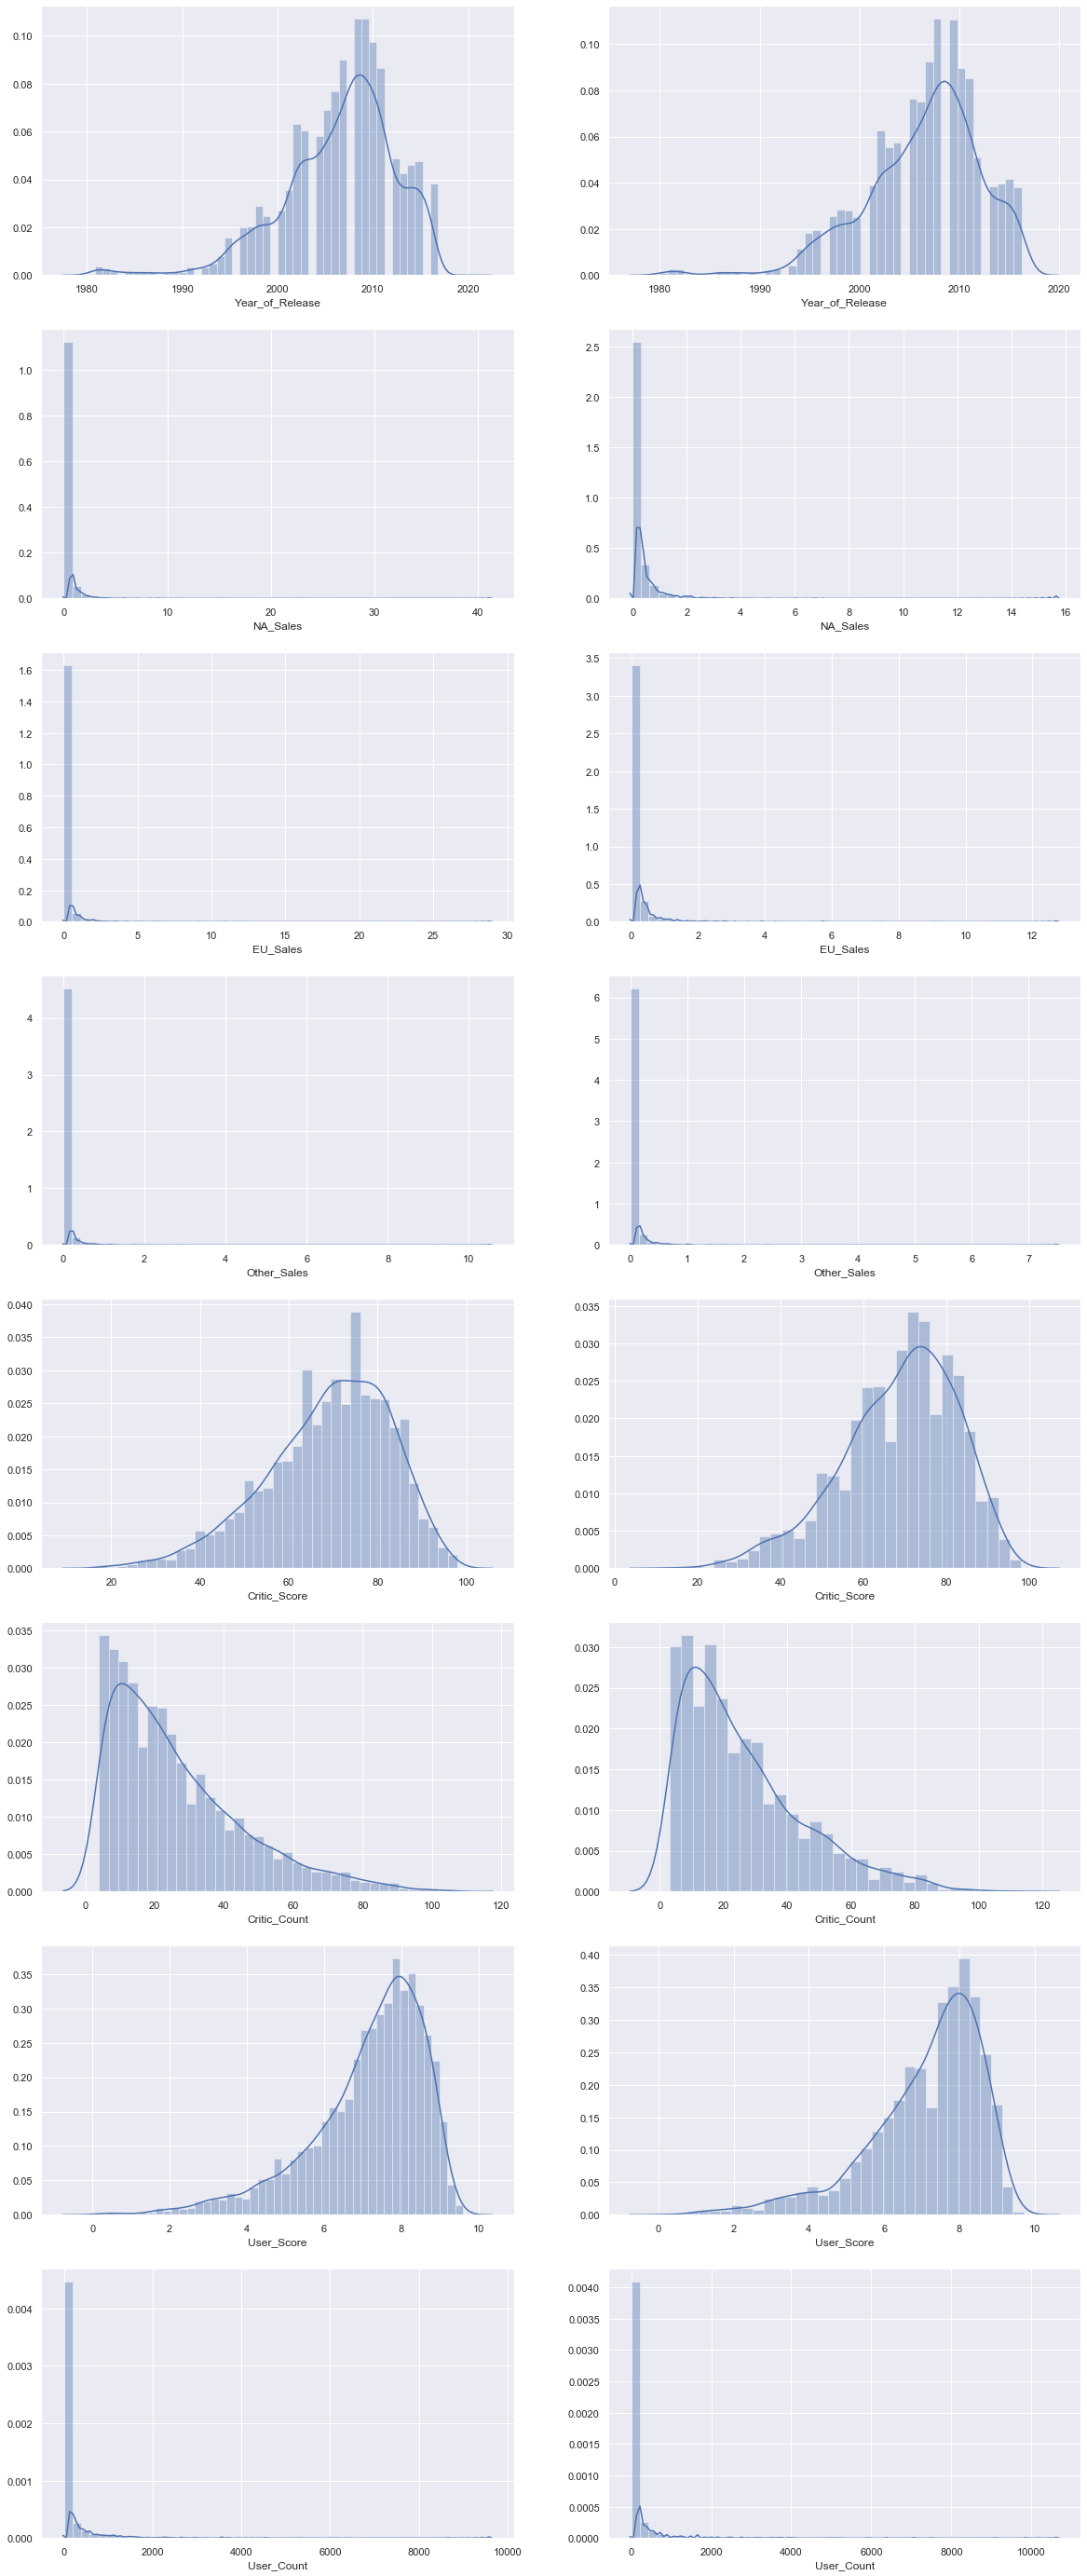

In [332]:
plt.figure(figsize=(20, 50))

for num, col in enumerate([i for i in df_train.columns if df_train[i].dtype != "object"]):
    plt.subplot(8,2,num*2+1)
    sns.distplot(df_train[col].dropna())
    plt.subplot(8,2,num*2+2)
    sns.distplot(df_test[col].dropna())

In [333]:
for col in df_train.columns:
    print("{}: тип - {}, % уникальных - {}, % пропусков - {}".format(col, 
                                                       df_train[col].dtype,
                                                       df_train[col].nunique() / df_train.shape[0] * 100,
                                                        df_train[col].isna().sum() / df_train.shape[0] * 100))

Name: тип - object, % уникальных - 75.0234982483124, % пропусков - 0.00854481756814492
Platform: тип - object, % уникальных - 0.25634452704434757, % пропусков - 0.0
Year_of_Release: тип - float64, % уникальных - 0.33324788515765186, % пропусков - 1.6662394257882593
Genre: тип - object, % уникальных - 0.10253781081773904, % пропусков - 0.00854481756814492
Publisher: тип - object, % уникальных - 4.4433051354353585, % пропусков - 0.32470306758950696
NA_Sales: тип - float64, % уникальных - 3.0590446893958814, % пропусков - 0.0
EU_Sales: тип - float64, % уникальных - 2.315645560967273, % пропусков - 0.0
Other_Sales: тип - float64, % уникальных - 1.1450055541314195, % пропусков - 0.0
Critic_Score: тип - float64, % уникальных - 0.6921302230197385, % пропусков - 51.49961548320944
Critic_Count: тип - float64, % уникальных - 0.8715713919507819, % пропусков - 51.49961548320944
User_Score: тип - float64, % уникальных - 0.7946680338374775, % пропусков - 54.550115355037164
User_Count: тип - float64,

__Видим, что некоторые переменные имеют числовой тип, но при этом очень низкое кол-во уникальных значений. Возможно, эти переменные стоит рассматривать как категориальные.__

__Также обращаем внимание на большое кол-во пропусков у некоторых переменных.__

__Cначала изучим переменные с большим кол-вом пропусков - Critic_Score, Critic_Count, User_Score, User_Count, Developer, Rating.__

__1) Critic_Score и Critic_Count__

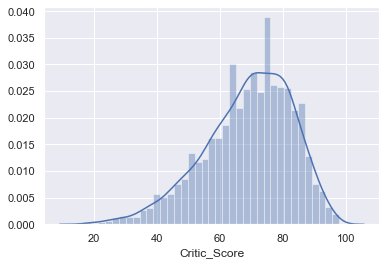

In [334]:
sns.distplot(df_train[pd.isnull(df_train["Critic_Score"]) == False]["Critic_Score"])

In [335]:
df_train[pd.isnull(df_train["Critic_Score"]) == False]["Critic_Score"].min()

17.0

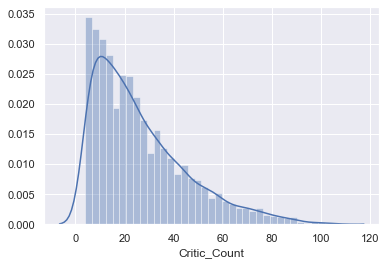

In [336]:
sns.distplot(df_train[pd.isnull(df_train["Critic_Count"]) == False]["Critic_Count"])

In [337]:
df_train[pd.isnull(df_train["Critic_Count"]) == False]["Critic_Count"].min()

4.0

In [338]:
df_train[pd.isnull(df_train["Critic_Count"])].isna().sum()

Name                  1
Platform              0
Year_of_Release      83
Genre                 1
Publisher            35
NA_Sales              0
EU_Sales              0
Other_Sales           0
Critic_Score       6027
Critic_Count       6027
User_Score         5628
User_Count         5628
Developer          4635
Rating             4686
dtype: int64

__Видим, что рейтинг и кол-во оценок критиков обычно принимают положительные значения. При этом пропуску в столбце Critic_Count всегда соответсвует пропуск в столбце Critic_Score.__

__Это означает, что критики не дали оценок игре.__

__2) User_Score и User_Count__

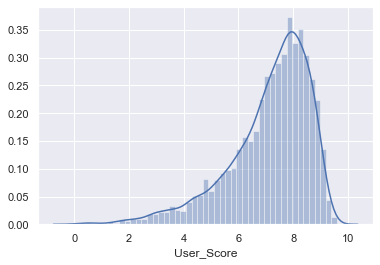

In [339]:
sns.distplot(df_train[pd.isnull(df_train["User_Score"]) == False]["User_Score"])

In [340]:
df_train[pd.isnull(df_train["User_Score"]) == False]["User_Score"].min()

0.0

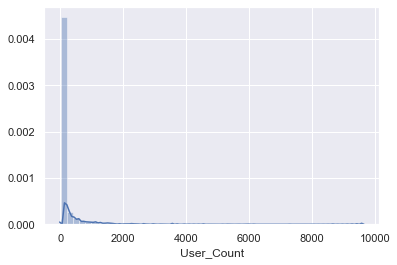

In [341]:
sns.distplot(df_train[pd.isnull(df_train["User_Count"]) == False]["User_Count"])

In [342]:
df_train[pd.isnull(df_train["User_Count"]) == False]["User_Count"].min()

4.0

In [343]:
df_train[pd.isnull(df_train["User_Count"])].isna().sum()

Name                  1
Platform              0
Year_of_Release      97
Genre                 1
Publisher            33
NA_Sales              0
EU_Sales              0
Other_Sales           0
Critic_Score       5628
Critic_Count       5628
User_Score         6384
User_Count         6384
Developer          4630
Rating             4681
dtype: int64

__Ситуация аналогична той, что мы видели в столбцах, характеризующих оценки критиков.__

__Следовательно, пропуски в столбцах с кол-вом оценок можно заполнить нулями. Пропуски в столбцах с оценками можно заполнить 0, но также необходимо создать индикатор отсутствия оценок.__

In [344]:
df_train["Critic_Score"].fillna(0, inplace=True)
df_test["Critic_Score"].fillna(0, inplace=True)

df_train["Critic_Count"].fillna(0, inplace=True)
df_test["Critic_Count"].fillna(0, inplace=True)

df_train["User_Score"].fillna(0, inplace=True)
df_test["User_Score"].fillna(0, inplace=True)

df_train["User_Count"].fillna(0, inplace=True)
df_test["User_Count"].fillna(0, inplace=True)


df_train["No_score"] = df_train["User_Count"].apply(lambda x: int(x == 0))
df_test["No_score"] = df_test["User_Count"].apply(lambda x: int(x == 0))

In [345]:
df_train.isna().sum()

Name                  1
Platform              0
Year_of_Release     195
Genre                 1
Publisher            38
NA_Sales              0
EU_Sales              0
Other_Sales           0
Critic_Score          0
Critic_Count          0
User_Score            0
User_Count            0
Developer          4639
Rating             4746
No_score              0
dtype: int64

__3) Developer__

In [346]:
df_train["Developer"].dtype

dtype('O')

In [347]:
df_train["Developer"].head()

0                Sand Grain Studios
1                          Nintendo
2    Eurocom Entertainment Software
3                               NaN
4                               NaN
Name: Developer, dtype: object

__Заполним пропуски значением "unknown".__

In [348]:
df_train["Developer"].fillna("unknown", inplace=True)

In [349]:
df_train[["Publisher", "Developer"]].groupby("Publisher").agg(lambda x: x.nunique()).sort_values(by="Developer", ascending=False)

,Developer
Publisher,
Ubisoft,153
Activision,135
Electronic Arts,123
Atari,110
THQ,109
...,...
Imadio,1
Illusion Softworks,1
IE Institute,1


In [350]:
df_train.drop("Developer", axis=1, inplace=True)
df_test.drop("Developer", axis=1, inplace=True)

__Столбец Publisher содержит значительную часть инфы о Developer при значительно меньшем кол-ве значений. Удалим столбец Developer.__

__4) Rating__

In [351]:
df_train["Rating"].value_counts()

E       2810
T       2072
M       1068
E10+     996
EC         6
K-A        3
AO         1
RP         1
Name: Rating, dtype: int64

__Создадим бинарные переменные для топ 3 категорий.__

__Перейдем к остальным переменным__

__5) Name__

In [352]:
def extract_game_name(x):
    k = 0
    for i in ["the", "super", "mega", "my", "final",
             "star", "disney", "just", "lego",
             "dead", "sega", "metal", "dark", "battle", "lost",
             "top", "wii", "pro", "power", "space",
             "shadow", "wild", "rock", "project", "jet", "unreal",
             "alien", "jewel", "we", "dance", "zoo",
             "street", "time", "red"]:
        if str(x).split()[0] == i:
            k += 1
        
    if k > 0:
        if len(str(x).split()) > 1:
            return str(x).split()[0] + " " + str(x).split()[1]
        else:
            return str(x).split()[0]
    elif len(str(x).split()) < 4:
        return str(x).split()[0]
    else:
        return str(x).split()[0] + " " + str(x).split()[1]

In [353]:
df_train["Name"] = df_train["Name"].apply(lambda x: str(x).lower())
df_test["Name"] = df_test["Name"].apply(lambda x: str(x).lower())

In [354]:
df_train["Name_modif"] = df_train["Name"].apply(lambda x: extract_game_name(x))

In [355]:
df_test["Name_modif"] = df_test["Name"].apply(lambda x: extract_game_name(x))

__6) Platform__

In [356]:
df_train.Platform.value_counts()

PS2     1519
DS      1464
PS3      936
Wii      924
PSP      880
X360     873
PS       827
PC       681
XB       581
GBA      561
GC       395
3DS      358
PSV      311
PS4      276
N64      226
XOne     184
SNES     170
SAT      113
WiiU     108
2600      95
NES       74
GB        73
DC        40
GEN       16
NG         5
SCD        5
WS         3
3DO        2
TG16       2
GG         1
Name: Platform, dtype: int64

__7) Year_of_Release__

In [357]:
df_train["Year_of_Release"].isna().sum()

195

In [358]:
median_year = df_train["Year_of_Release"].median()

In [359]:
df_train["Year_of_Release"].fillna(median_year, inplace=True)

In [360]:
df_test["Year_of_Release"].fillna(median_year, inplace=True)

In [361]:
df_train.Year_of_Release.nunique()

39

In [362]:
df_train["Name_plat"] = df_train[["Name", "Platform"]].apply(lambda x: str(x[0]) + str(x[1]), axis=1)
df_test["Name_plat"] = df_test[["Name", "Platform"]].apply(lambda x: str(x[0]) + str(x[1]), axis=1)

In [363]:
df_train["Name_plat"] 

0                                   rapala trophiesPSP
1                          new super mario bros. uWiiU
2                                            robotsPS2
3                                    hamster club 3GBA
4                                      formula 1 06PS2
                             ...                      
11698                      call of duty: black opsX360
11699                                  resistance 3PS3
11700                     ready 2 rumble revolutionWii
11701    monster hunter frontier online: forward 2X360
11702                                       nhl 2k9PS3
Name: Name_plat, Length: 11703, dtype: object

In [364]:
df_train["Name_plat_y"] = df_train[["Name_plat", "Year_of_Release"]].apply(lambda x: str(x[0]) + str(x[1]), axis=1)
df_test["Name_plat_y"] = df_test[["Name_plat", "Year_of_Release"]].apply(lambda x: str(x[0]) + str(x[1]), axis=1)

In [365]:
df_train["Name_plat_y"]

0                                 rapala trophiesPSP2006.0
1                        new super mario bros. uWiiU2012.0
2                                          robotsPS22005.0
3                                  hamster club 3GBA2002.0
4                                    formula 1 06PS22006.0
                               ...                        
11698                    call of duty: black opsX3602010.0
11699                                resistance 3PS32011.0
11700                   ready 2 rumble revolutionWii2009.0
11701    monster hunter frontier online: forward 2X3602...
11702                                     nhl 2k9PS32008.0
Name: Name_plat_y, Length: 11703, dtype: object

In [366]:
np.intersect1d(np.array([str(i) for i in df_train.Name_plat.unique().tolist()]), 
               np.array([str(i) for i in df_test.Name_plat.unique().tolist()]))

array(['nanGEN'], dtype='<U134')

In [367]:
np.vstack((np.array(df_train.Name_modif.value_counts().index.tolist()[:40]),
    np.array(df_test.Name_modif.value_counts().index.tolist()[:40])))

array([['nba', 'fifa', 'nhl', 'madden', "tom clancy's", 'need for',
        'jikkyou powerful', 'mega man', 'call of', 'final fantasy',
        'the legend', 'tiger woods', 'ncaa', 'the sims', 'star wars:',
        'dragon ball', 'nfl', 'pro evolution', 'harry potter',
        'super robot', 'monster', 'metal gear', 'star wars', 'nascar',
        'just dance', 'major league', 'the king', "tony hawk's", 'wwe',
        'sonic', 'mobile suit', 'dragon', 'lego star', 'dragon quest',
        'mario', 'imagine:', 'singstar', 'super mario', "assassin's",
        'f1'],
       ['fifa', 'nba', 'madden', 'final fantasy', 'nhl', 'need for',
        'call of', "tom clancy's", 'pro evolution', 'dragon ball',
        'jikkyou powerful', 'the sims', 'the legend', "tony hawk's",
        'harry potter', 'nfl', 'world', 'major league', 'ncaa',
        'dragon quest', 'f1', 'dance dance', 'tiger woods',
        'super robot', 'rock band', 'naruto shippuden:', 'monster',
        'just dance', 'star wars:'

In [368]:
top_games = np.intersect1d(np.array(df_train.Name_modif.value_counts().index.tolist()[:40]),
    np.array(df_test.Name_modif.value_counts().index.tolist()[:40])).tolist()

In [369]:
df_train["Names_top"] = df_train["Name_modif"].apply(lambda x: x if x in top_games else "shit")
df_test["Names_top"] = df_test["Name_modif"].apply(lambda x: x if x in top_games else "shit")

In [370]:
df_train.drop(['Name_plat', 'Name_plat_y'], axis=1, inplace=True)
df_test.drop(['Name_plat', 'Name_plat_y'], axis=1, inplace=True)

In [371]:
df_train.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,No_score,Name_modif,Names_top
0,rapala trophies,PSP,2006.0,Sports,Activision,0.04,0.00,0.00,0.0,0.0,0.0,0.0,E,1,rapala,shit
1,new super mario bros. u,WiiU,2012.0,Platform,Nintendo,2.30,1.34,0.32,84.0,70.0,8.1,733.0,E,0,new super,shit
2,robots,PS2,2005.0,Action,Vivendi Games,0.18,0.14,0.05,53.0,6.0,6.0,8.0,E,0,robots,shit
3,hamster club 3,GBA,2002.0,Simulation,Jorudan,0.00,0.00,0.01,0.0,0.0,0.0,0.0,NaN,1,hamster,shit
4,formula 1 06,PS2,2006.0,Racing,Sony Computer Entertainment,0.00,0.00,0.00,0.0,0.0,0.0,0.0,NaN,1,formula,shit


__8) Rating__

In [372]:
df_train["Rating"].value_counts() / df_train.shape[0]

E       0.240109
T       0.177049
M       0.091259
E10+    0.085106
EC      0.000513
K-A     0.000256
AO      0.000085
RP      0.000085
Name: Rating, dtype: float64

In [373]:
df_train.drop("Rating", axis=1, inplace=True)
df_test.drop("Rating", axis=1, inplace=True)

__9) Genre__

In [374]:
df_train["Genre"].value_counts()

Action          2399
Sports          1639
Misc            1216
Role-Playing    1033
Shooter          919
Adventure        911
Racing           883
Platform         634
Simulation       613
Fighting         582
Strategy         473
Puzzle           400
Name: Genre, dtype: int64

In [375]:
df_train.Genre.isna().sum()

1

In [376]:
df_train["Genre"].fillna("Puzzle", inplace=True)
df_test["Genre"].fillna("Puzzle", inplace=True)

__10) Publisher__

In [377]:
df_train["Publisher"].fillna("Unknown", inplace=True)

In [378]:
df_test["Publisher"].fillna("Unknown", inplace=True)

In [379]:
publish_df = pd.DataFrame(columns=["publisher", "freq", "cumul_freq"], index=range(df_train["Publisher"].nunique()))

In [380]:
publish_df["publisher"] = df_train["Publisher"].value_counts().index.tolist()
publish_df["freq"] = df_train["Publisher"].value_counts().tolist()
publish_df["freq"] = publish_df["freq"] / df_train.shape[0]

In [381]:
publish_df["cumul_freq"] = publish_df["freq"].cumsum()

In [382]:
publish_df.iloc[:40, :]

,publisher,freq,cumul_freq
0,Electronic Arts,0.079809,0.079809
1,Activision,0.058532,0.138341
2,Ubisoft,0.057079,0.195420
3,Namco Bandai Games,0.055712,0.251132
4,Konami Digital Entertainment,0.048278,0.299410
5,Nintendo,0.042639,0.342049
6,THQ,0.041870,0.383919
7,Sony Computer Entertainment,0.041015,0.424934
8,Sega,0.036572,0.461506
9,Take-Two Interactive,0.025805,0.487311


In [383]:
main_publish = publish_df.iloc[:35, 0].tolist()

In [384]:
main_publish

['Electronic Arts',
 'Activision',
 'Ubisoft',
 'Namco Bandai Games',
 'Konami Digital Entertainment',
 'Nintendo',
 'THQ',
 'Sony Computer Entertainment',
 'Sega',
 'Take-Two Interactive',
 'Capcom',
 'Atari',
 'Tecmo Koei',
 'Unknown',
 'Square Enix',
 'Warner Bros. Interactive Entertainment',
 'Disney Interactive Studios',
 '505 Games',
 'Eidos Interactive',
 'Microsoft Game Studios',
 'Acclaim Entertainment',
 'Midway Games',
 'D3Publisher',
 'Vivendi Games',
 'Codemasters',
 'Idea Factory',
 'Deep Silver',
 'Zoo Digital Publishing',
 'LucasArts',
 'Nippon Ichi Software',
 'Rising Star Games',
 'Majesco Entertainment',
 'Hudson Soft',
 'Atlus',
 'Banpresto']

In [385]:
df_train["Publisher"] = df_train["Publisher"].apply(lambda x: x if x in main_publish else "Unknown")

In [386]:
df_test["Publisher"] = df_test["Publisher"].apply(lambda x: x if x in main_publish else "Unknown")

In [387]:
df_train["Publisher"].value_counts()

Unknown                                   3022
Electronic Arts                            934
Activision                                 685
Ubisoft                                    668
Namco Bandai Games                         652
Konami Digital Entertainment               565
Nintendo                                   499
THQ                                        490
Sony Computer Entertainment                480
Sega                                       428
Take-Two Interactive                       302
Capcom                                     279
Atari                                      257
Tecmo Koei                                 245
Square Enix                                165
Warner Bros. Interactive Entertainment     163
Disney Interactive Studios                 157
505 Games                                  143
Eidos Interactive                          140
Microsoft Game Studios                     134
Midway Games                               133
Acclaim Enter

__11) Sales__

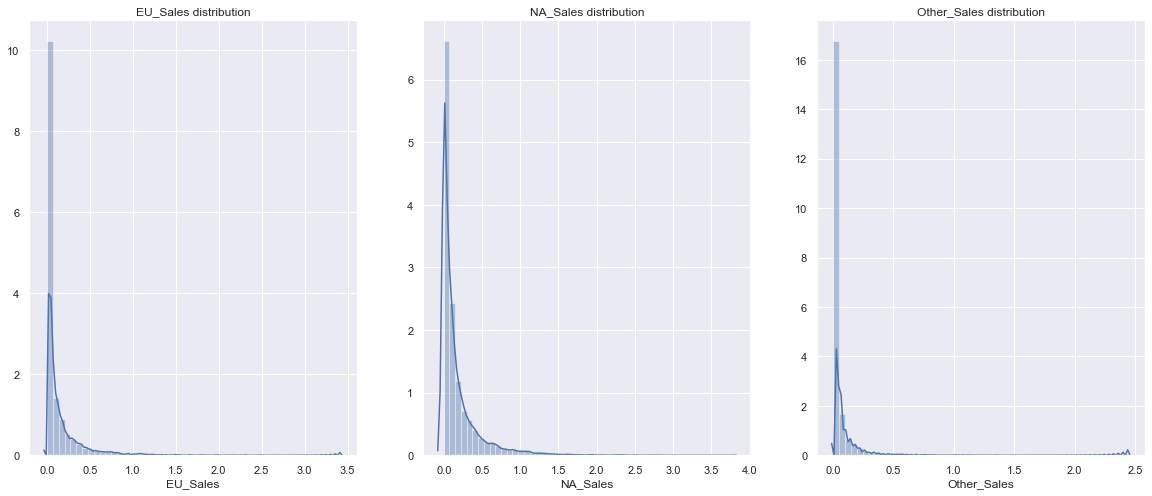

In [388]:
plt.figure(figsize=(20, 8))

for num, col in enumerate(["EU_Sales", "NA_Sales", "Other_Sales"]):
    plt.subplot(1, 3, num+1)
    sns.distplot(df_train[col].apply(lambda x: np.log(1+x)))
    plt.title(col + " distribution")

In [389]:
df_train["Total_Sales"] = df_train["EU_Sales"] + df_train["NA_Sales"] + df_train["Other_Sales"]
df_test["Total_Sales"] = df_test["EU_Sales"] + df_test["NA_Sales"] + df_test["Other_Sales"]


for col in ["EU_Sales", "NA_Sales", "Other_Sales", "Total_Sales"]:
    df_train[col + "_zero"] = df_train[col].apply(lambda x: int(x == 0))
    df_test[col + "_zero"] = df_test[col].apply(lambda x: int(x == 0))
    

In [390]:
df_test.columns.shape

(20,)

In [391]:
df_test.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'Other_Sales', 'Critic_Score', 'Critic_Count', 'User_Score',
       'User_Count', 'No_score', 'Name_modif', 'Names_top', 'Total_Sales',
       'EU_Sales_zero', 'NA_Sales_zero', 'Other_Sales_zero',
       'Total_Sales_zero'],
      dtype='object')

__Генерим версии игры__

__Для этого нам понадобится Name и Year_of_Release__

In [392]:
df = pd.concat([df_train, df_test], axis=0)

In [393]:
df.shape

(16719, 20)

__Напишем функцию для простановки версий__

In [394]:
df['version'] = df.groupby(["Name_modif", "Platform"])['Year_of_Release'].rank(method='first')

In [395]:
df.shape

(16719, 21)

In [396]:
df.nunique()

Name                11563
Platform               31
Year_of_Release        39
Genre                  12
Publisher              35
NA_Sales              402
EU_Sales              307
Other_Sales           155
Critic_Score           83
Critic_Count          107
User_Score             95
User_Count            889
No_score                2
Name_modif           6194
Names_top              33
Total_Sales           886
EU_Sales_zero           2
NA_Sales_zero           2
Other_Sales_zero        2
Total_Sales_zero        2
version                31
dtype: int64

In [397]:
def count_versions(x):
    return int(df[df["Name_modif"] == x]["version"].nunique() > 5)

In [398]:
df["many_versions"] = df["Name_modif"].apply(lambda x: count_versions(x))

In [399]:
df.drop("Name", axis=1, inplace=True)

In [400]:
df.drop('Name_modif', axis=1, inplace=True)

In [401]:
for col in ["Critic_Score","Critic_Count", "User_Score", "User_Count", "version"]:
    bin_width = (df[col].max() - df[col].min()) / 20
    df[col] = df[col] // bin_width

In [402]:
df.nunique()

Platform             31
Year_of_Release      39
Genre                12
Publisher            35
NA_Sales            402
EU_Sales            307
Other_Sales         155
Critic_Score         19
Critic_Count         20
User_Score           20
User_Count           21
No_score              2
Names_top            33
Total_Sales         886
EU_Sales_zero         2
NA_Sales_zero         2
Other_Sales_zero      2
Total_Sales_zero      2
version              21
many_versions         2
dtype: int64

In [403]:
for col in df.columns:
    if df[col].nunique() <= 40:
        df[col] = df[col].astype("category")

In [404]:
df.dtypes

Platform            category
Year_of_Release     category
Genre               category
Publisher           category
NA_Sales             float64
EU_Sales             float64
Other_Sales          float64
Critic_Score        category
Critic_Count        category
User_Score          category
User_Count          category
No_score            category
Names_top           category
Total_Sales          float64
EU_Sales_zero       category
NA_Sales_zero       category
Other_Sales_zero    category
Total_Sales_zero    category
version             category
many_versions       category
dtype: object

In [405]:
df = pd.get_dummies(df)

In [406]:
df_train = df.iloc[:11703, :]
df_test = df.iloc[11703:, :]

In [407]:
train_cols = [i for i in df_train.columns if df_train[i].nunique() > 1]
test_cols = [i for i in df_test.columns if df_test[i].nunique() > 1]

common_cols = np.intersect1d(np.array(train_cols), np.array(test_cols))

In [408]:
df_train = df_train[common_cols]
df_test = df_test[common_cols]

__Шкалируем признаки__

In [409]:
for col in common_cols:
    max = df_train[col].max()
    min = df_train[col].min()
    df_train[col] = (df_train[col] - min) / (max - min)
    
    max = df_test[col].max()
    min = df_test[col].min()
    df_test[col] = (df_test[col] - min) / (max - min)

__Отберем лучшие признаки__

In [410]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.25, random_state=1)

In [411]:
from sklearn.linear_model import LinearRegression

In [412]:
all_cols = df_train.columns

best_cols = []

model = LinearRegression()

In [413]:
dict_mae = {}

for _ in tqdm(range(50)):
    dict_mae_aux = {}
    for feat in [col for col in all_cols if "div" not in col]:
        if feat not in best_cols:
            best_cols.append(feat)
            if len(best_cols) == 1:
                model.fit(np.array(X_train[best_cols]).reshape(-1,1), y_train)
                y_pred = model.predict(np.array(X_test[best_cols]).reshape(-1,1))
            else:
                model.fit(X_train[best_cols], y_train)
                y_pred = model.predict(X_test[best_cols])
            best_cols.pop()
            dict_mae_aux[feat] = mean_absolute_error(y_test, y_pred)
    best_col, best_mae = sorted(dict_mae_aux.items(), key=lambda x: x[1])[0]
    best_cols.append(best_col)
    dict_mae[tuple(best_cols)] = best_mae 

100%|██████████| 50/50 [01:13<00:00,  1.47s/it]


In [414]:
dict_mae

{('Publisher_Nintendo',): 0.10345846598584303,
 ('Publisher_Nintendo', 'Total_Sales_zero_0'): 0.09834468795156476,
 ('Publisher_Nintendo', 'Total_Sales_zero_0', 'NA_Sales'): 0.09007722873230316,
 ('Publisher_Nintendo',
  'Total_Sales_zero_0',
  'NA_Sales',
  'Platform_NES'): 0.08805369825136303,
 ('Publisher_Nintendo',
  'Total_Sales_zero_0',
  'NA_Sales',
  'Platform_NES',
  'Platform_SNES'): 0.0863710835852594,
 ('Publisher_Nintendo',
  'Total_Sales_zero_0',
  'NA_Sales',
  'Platform_NES',
  'Platform_SNES',
  'Names_top_dragon quest'): 0.08479779369249553,
 ('Publisher_Nintendo',
  'Total_Sales_zero_0',
  'NA_Sales',
  'Platform_NES',
  'Platform_SNES',
  'Names_top_dragon quest',
  'Names_top_final fantasy'): 0.08346983483463656,
 ('Publisher_Nintendo',
  'Total_Sales_zero_0',
  'NA_Sales',
  'Platform_NES',
  'Platform_SNES',
  'Names_top_dragon quest',
  'Names_top_final fantasy',
  'Publisher_Namco Bandai Games'): 0.08289017489045414,
 ('Publisher_Nintendo',
  'Total_Sales_zero_

Text(0.5, 1.0, 'Test MAE vs number of features')

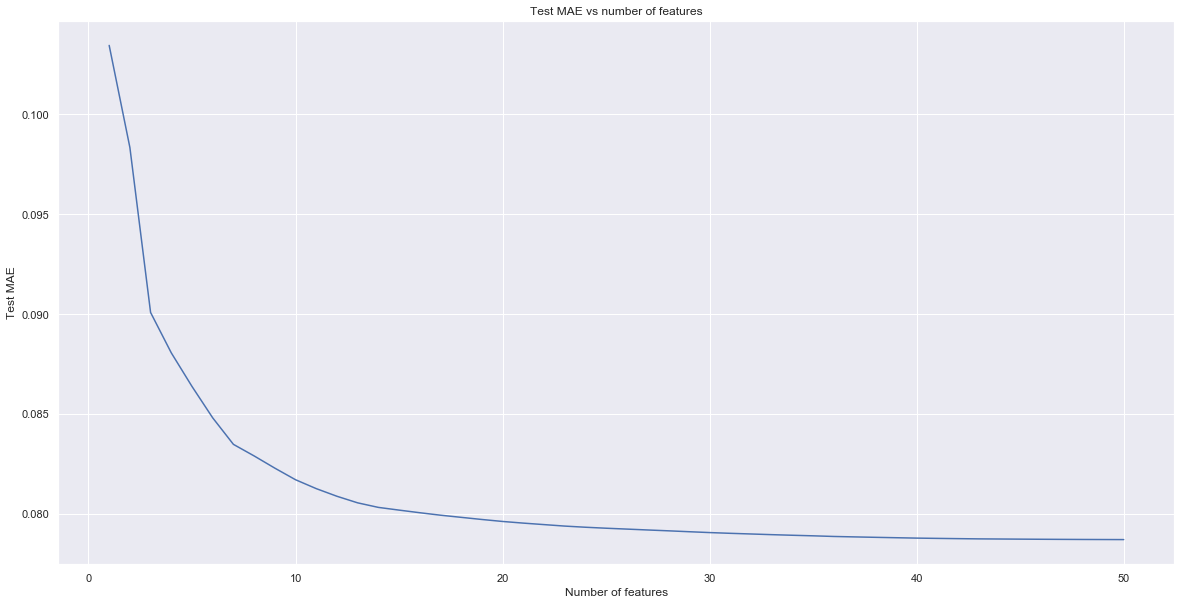

In [415]:
plt.figure(figsize=(20,10))
sns.lineplot(x=range(1,51), y=list(dict_mae.values()))
plt.xlabel("Number of features")
plt.ylabel("Test MAE")
plt.title("Test MAE vs number of features")

__Отберем 20 признаков__

In [416]:
chosen_features = list(list(dict_mae.items())[19][0])

In [417]:
chosen_features

['Publisher_Nintendo',
 'Total_Sales_zero_0',
 'NA_Sales',
 'Platform_NES',
 'Platform_SNES',
 'Names_top_dragon quest',
 'Names_top_final fantasy',
 'Publisher_Namco Bandai Games',
 'Names_top_jikkyou powerful',
 'Platform_GB',
 'Platform_SAT',
 'Names_top_mario',
 'Names_top_monster',
 'Names_top_super robot',
 'Publisher_Tecmo Koei',
 'Critic_Count_16.0',
 'Year_of_Release_1991.0',
 'Platform_DC',
 'Names_top_madden',
 'Publisher_Atlus']

In [418]:
df_train[chosen_features].corr()

,Publisher_Nintendo,Total_Sales_zero_0,NA_Sales,Platform_NES,Platform_SNES,Names_top_dragon quest,Names_top_final fantasy,Publisher_Namco Bandai Games,Names_top_jikkyou powerful,Platform_GB,Platform_SAT,Names_top_mario,Names_top_monster,Names_top_super robot,Publisher_Tecmo Koei,Critic_Count_16.0,Year_of_Release_1991.0,Platform_DC,Names_top_madden,Publisher_Atlus
Publisher_Nintendo,1.000000,0.003684,0.239618,0.175242,0.069817,-0.000218,0.000555,-0.051261,-0.014234,0.225005,-0.020838,0.205454,0.005580,-0.010876,-0.030860,-0.006761,0.078038,-0.012359,-0.014894,-0.014099
Total_Sales_zero_0,0.003684,1.000000,0.147680,-0.002326,-0.178857,-0.021182,0.009147,-0.249436,-0.106349,-0.058063,-0.200840,0.022043,-0.004531,-0.072166,-0.120118,0.015579,-0.061915,-0.105544,0.034317,-0.026317
NA_Sales,0.239618,0.147680,1.000000,0.099488,0.008482,-0.007702,0.011670,-0.053775,-0.020485,0.105837,-0.029781,0.068322,-0.008627,-0.015502,-0.038142,0.066863,0.000673,-0.012490,0.072527,-0.015237
Platform_NES,0.175242,-0.002326,0.099488,1.000000,-0.009685,-0.003616,0.047297,0.018223,-0.005380,-0.006320,-0.007877,0.020213,-0.004111,-0.004111,-0.011665,-0.002556,0.140327,-0.004672,-0.005630,-0.005329
Platform_SNES,0.069817,-0.178857,0.008482,-0.009685,1.000000,0.010283,0.003996,0.042125,0.023721,-0.009619,-0.011988,0.010283,-0.006257,-0.006257,0.012177,-0.003890,0.239818,-0.007110,-0.008568,-0.008111
Names_top_dragon quest,-0.000218,-0.021182,-0.007702,-0.003616,0.010283,1.000000,-0.002816,-0.011011,-0.003058,-0.003591,-0.004476,-0.002055,-0.002336,-0.002336,-0.006629,-0.001452,-0.002374,-0.002655,-0.003199,-0.003028
Names_top_final fantasy,0.000555,0.009147,0.011670,0.047297,0.003996,-0.002816,1.000000,-0.015091,-0.004191,0.012614,-0.006135,-0.002816,-0.003202,-0.003202,-0.009085,-0.001990,0.023186,-0.003638,-0.004385,-0.004151
Publisher_Namco Bandai Games,-0.051261,-0.249436,-0.053775,0.018223,0.042125,-0.011011,-0.015091,1.000000,-0.016383,-0.009780,-0.004935,-0.011011,-0.012518,0.074458,-0.035518,-0.007782,0.008684,-0.007842,-0.017142,-0.016227
Names_top_jikkyou powerful,-0.014234,-0.106349,-0.020485,-0.005380,0.023721,-0.003058,-0.004191,-0.016383,1.000000,-0.005344,-0.006660,-0.003058,-0.003476,-0.003476,-0.009863,-0.002161,-0.003532,0.017855,-0.004760,-0.004506
Platform_GB,0.225005,-0.058063,0.105837,-0.006320,-0.009619,-0.003591,0.012614,-0.009780,-0.005344,1.000000,-0.007823,0.020399,-0.004083,-0.004083,-0.011585,-0.002538,0.141335,-0.004640,-0.005591,-0.005293


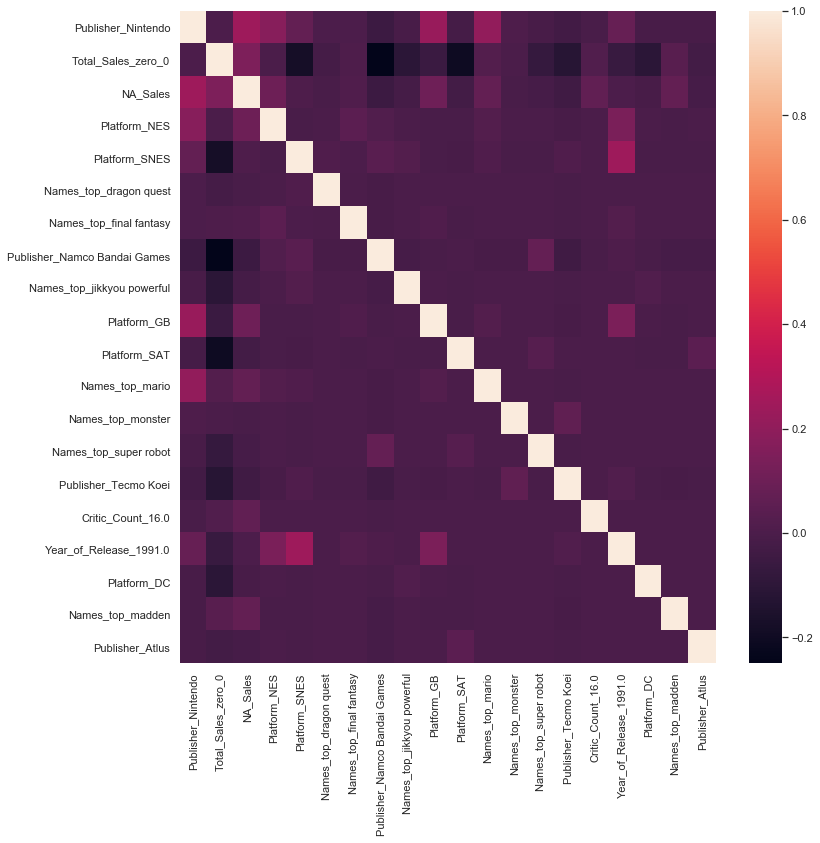

In [419]:
plt.figure(figsize=(12,12))
sns.heatmap(df_train[chosen_features].corr())

In [420]:
best_features_train = df_train[chosen_features]
best_features_test = df_test[chosen_features]

In [421]:
cols_to_use = chosen_features

In [422]:
for col1 in tqdm(chosen_features):
    cols_to_use.remove(col1)
    for col2 in cols_to_use:
        best_features_train[col1 + "_" + col2 + "_mult"] = best_features_train[col1] * best_features_train[col2]
        best_features_test[col1 + "_" + col2 + "_mult"] = best_features_test[col1] * best_features_test[col2]
        best_features_train[col1 + "_" + col2 + "_sum"] = best_features_train[col1] + best_features_train[col2]
        best_features_test[col1 + "_" + col2 + "_sum"] = best_features_test[col1] + best_features_test[col2]
        best_features_train[col1 + "_" + col2 + "_diff"] = best_features_train[col1] - best_features_train[col2]
        best_features_test[col1 + "_" + col2 + "_diff"] = best_features_test[col1] - best_features_test[col2]

 50%|█████     | 10/20 [00:00<00:00, 10.47it/s]


In [423]:
all_cols1 = best_features_train.columns

In [424]:
cols_to_drop_train = []
cols_to_drop_test = []

In [425]:
for col in tqdm(all_cols1):
    if best_features_train[col].nunique() < 2:
        cols_to_drop_train.append(col)
    if best_features_test[col].nunique() < 2:
        cols_to_drop_test.append(col)

100%|██████████| 455/455 [00:00<00:00, 2462.64it/s]


In [426]:
best_features_train.drop(cols_to_drop_train, axis=1, inplace=True)
best_features_test.drop(cols_to_drop_test, axis=1, inplace=True)

In [427]:
common_cols = np.intersect1d(np.array(best_features_train.columns), np.array(best_features_test.columns))

In [428]:
best_features_train = best_features_train[common_cols]
best_features_test = best_features_test[common_cols]

In [429]:
from sklearn.preprocessing import MinMaxScaler

In [430]:
minmax = MinMaxScaler(feature_range=(0,1))

In [431]:
feat_train = pd.DataFrame(minmax.fit_transform(best_features_train))
feat_test = pd.DataFrame(minmax.fit_transform(best_features_test))

In [432]:
feat_train.columns = common_cols
feat_test.columns = common_cols

In [433]:
all_cols = feat_train.columns

best_cols = []

model = LinearRegression()

In [434]:
X_train, X_test, y_train, y_test = train_test_split(feat_train, y, test_size=0.25, random_state=4)

In [435]:
dict_mae = {}

for _ in tqdm(range(60)):
    dict_mae_aux = {}
    for feat in [col for col in all_cols if "div" not in col]:
        if feat not in best_cols:
            best_cols.append(feat)
            if len(best_cols) == 1:
                model.fit(np.array(X_train[best_cols]).reshape(-1,1), y_train)
                y_pred = model.predict(np.array(X_test[best_cols]).reshape(-1,1))
            else:
                model.fit(X_train[best_cols], y_train)
                y_pred = model.predict(X_test[best_cols])
            best_cols.pop()
            dict_mae_aux[feat] = mean_absolute_error(y_test, y_pred)
    best_col, best_mae = sorted(dict_mae_aux.items(), key=lambda x: x[1])[0]
    best_cols.append(best_col)
    dict_mae[tuple(best_cols)] = best_mae 

100%|██████████| 60/60 [02:19<00:00,  2.32s/it]


Text(0.5, 1.0, 'Test MAE vs number of features')

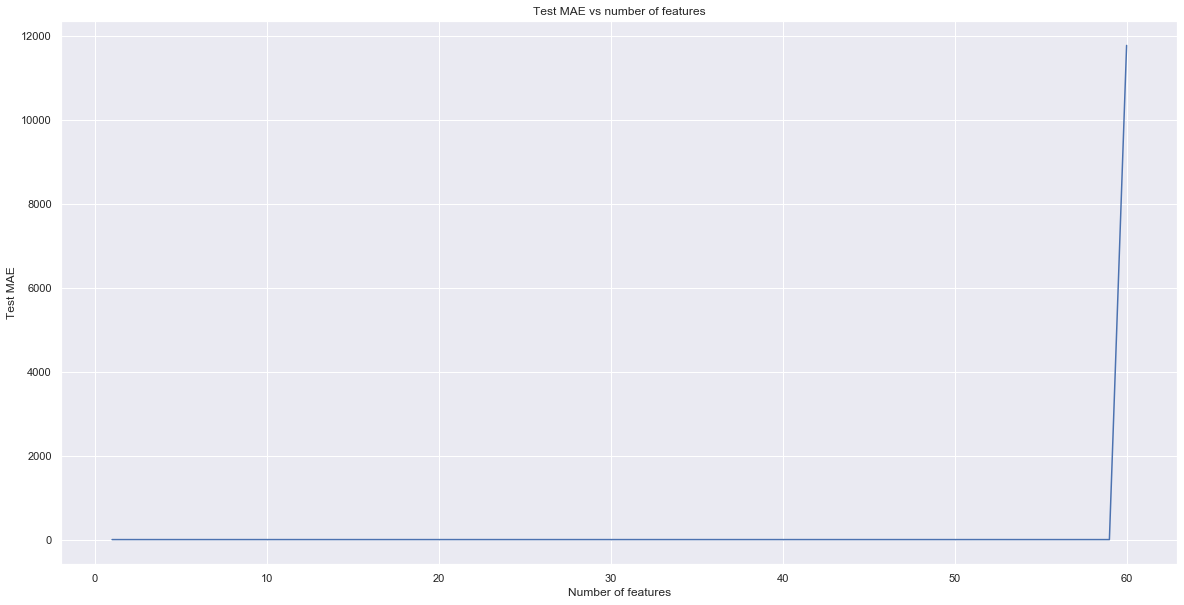

In [436]:
plt.figure(figsize=(20,10))
sns.lineplot(x=range(1,61), y=list(dict_mae.values())[:60])
plt.xlabel("Number of features")
plt.ylabel("Test MAE")
plt.title("Test MAE vs number of features")

__Отберем 20 признаков__

In [443]:
chosen_features = list(list(dict_mae.items())[19][0])

In [444]:
chosen_features

['Publisher_Nintendo_Platform_NES_sum',
 'Platform_SNES_Total_Sales_zero_0_diff',
 'NA_Sales_Names_top_dragon quest_sum',
 'Publisher_Nintendo_NA_Sales_mult',
 'NA_Sales_Names_top_final fantasy_mult',
 'Platform_SNES_Publisher_Namco Bandai Games_sum',
 'Publisher_Nintendo_Platform_GB_diff',
 'NA_Sales_Platform_NES_mult',
 'NA_Sales_Names_top_dragon quest_mult',
 'Names_top_jikkyou powerful_Names_top_monster_sum',
 'NA_Sales_Publisher_Tecmo Koei_mult',
 'NA_Sales_Names_top_dragon quest_diff',
 'Publisher_Nintendo_Names_top_super robot_diff',
 'Platform_SAT_Platform_DC_sum',
 'Names_top_final fantasy_Names_top_mario_sum',
 'NA_Sales_Publisher_Atlus_mult',
 'Publisher_Nintendo_Total_Sales_zero_0_mult',
 'Names_top_monster_Platform_GB_diff',
 'Names_top_jikkyou powerful_Total_Sales_zero_0_mult',
 'Platform_SAT_Names_top_madden_sum']

In [445]:
chosen_features.remove('Publisher_Nintendo_Platform_GB_diff')
chosen_features.remove('Publisher_Nintendo_Names_top_super robot_diff')
chosen_features.remove('Publisher_Nintendo_Total_Sales_zero_0_mult')
chosen_features.remove('Platform_SAT_Names_top_madden_sum')

In [446]:
model.fit(X_train[chosen_features], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [447]:
model.coef_

array([ 0.67459336,  0.12240793,  1.06243571,  9.63310116,  3.30588164,
        0.18400032, -4.62582378,  2.88691156,  0.1949537 ,  0.81104425,
        1.22858332,  0.08842943,  0.05583925,  0.29630533, -0.25730839,
        0.09134982])

In [448]:
mean_absolute_error(y_test, model.predict(X_test[chosen_features]))

0.07897968015280972

In [449]:
best_train = feat_train[chosen_features]
best_test = feat_test[chosen_features]

In [450]:
best_train.corr()

,Publisher_Nintendo_Platform_NES_sum,Platform_SNES_Total_Sales_zero_0_diff,NA_Sales_Names_top_dragon quest_sum,Publisher_Nintendo_NA_Sales_mult,NA_Sales_Names_top_final fantasy_mult,Platform_SNES_Publisher_Namco Bandai Games_sum,NA_Sales_Platform_NES_mult,NA_Sales_Names_top_dragon quest_mult,Names_top_jikkyou powerful_Names_top_monster_sum,NA_Sales_Publisher_Tecmo Koei_mult,NA_Sales_Names_top_dragon quest_diff,Platform_SAT_Platform_DC_sum,Names_top_final fantasy_Names_top_mario_sum,NA_Sales_Publisher_Atlus_mult,Names_top_monster_Platform_GB_diff,Names_top_jikkyou powerful_Total_Sales_zero_0_mult
Publisher_Nintendo_Platform_NES_sum,1.000000,0.013900,0.104090,0.349858,-0.002792,-0.007421,0.179483,0.018642,-0.009314,-0.014929,0.106066,-0.024544,0.124550,-0.008529,-0.161756,-0.006236
Platform_SNES_Total_Sales_zero_0_diff,0.013900,1.000000,-0.036801,-0.023666,-0.016188,0.408975,-0.011077,-0.011872,0.083870,-0.028190,-0.076543,0.203341,-0.016047,-0.019091,-0.040736,-0.013959
NA_Sales_Names_top_dragon quest_sum,0.104090,-0.036801,1.000000,0.346247,0.018163,-0.022951,0.177761,0.498700,-0.012754,-0.006478,-0.632707,-0.018507,0.018244,-0.003247,-0.038480,-0.005019
Publisher_Nintendo_NA_Sales_mult,0.349858,-0.023666,0.346247,1.000000,-0.002344,-0.000563,0.501723,0.002873,-0.005342,-0.005193,0.347326,-0.008538,0.051089,-0.002967,-0.124271,-0.002169
NA_Sales_Names_top_final fantasy_mult,-0.002792,-0.016188,0.018163,-0.002344,1.000000,-0.009052,-0.000315,-0.000843,-0.002883,-0.002374,0.020825,-0.003903,0.440349,-0.001356,0.001292,-0.000992
Platform_SNES_Publisher_Namco Bandai Games_sum,-0.007421,0.408975,-0.022951,-0.000563,-0.009052,1.000000,-0.004056,-0.006639,-0.011156,-0.010124,-0.013946,-0.013570,-0.012074,-0.010676,0.003275,-0.007806
NA_Sales_Platform_NES_mult,0.179483,-0.011077,0.177761,0.501723,-0.000315,-0.004056,1.000000,-0.000577,-0.001973,-0.001625,0.178599,-0.002671,0.000683,-0.000928,0.000884,-0.000679
NA_Sales_Names_top_dragon quest_mult,0.018642,-0.011872,0.498700,0.002873,-0.000843,-0.006639,-0.000577,1.000000,-0.002115,-0.001741,-0.492755,-0.002863,-0.001915,-0.000995,0.000948,-0.000727
Names_top_jikkyou powerful_Names_top_monster_sum,-0.009314,0.083870,-0.012754,-0.005342,-0.002883,-0.011156,-0.001973,-0.002115,1.000000,0.029641,-0.005734,-0.000875,-0.006548,-0.003401,0.336347,0.343939
NA_Sales_Publisher_Tecmo Koei_mult,-0.014929,-0.028190,-0.006478,-0.005193,-0.002374,-0.010124,-0.001625,-0.001741,0.029641,1.000000,-0.000722,-0.008058,-0.005392,-0.002800,0.034564,-0.002047


__Посмотрим на корреляции признаков__

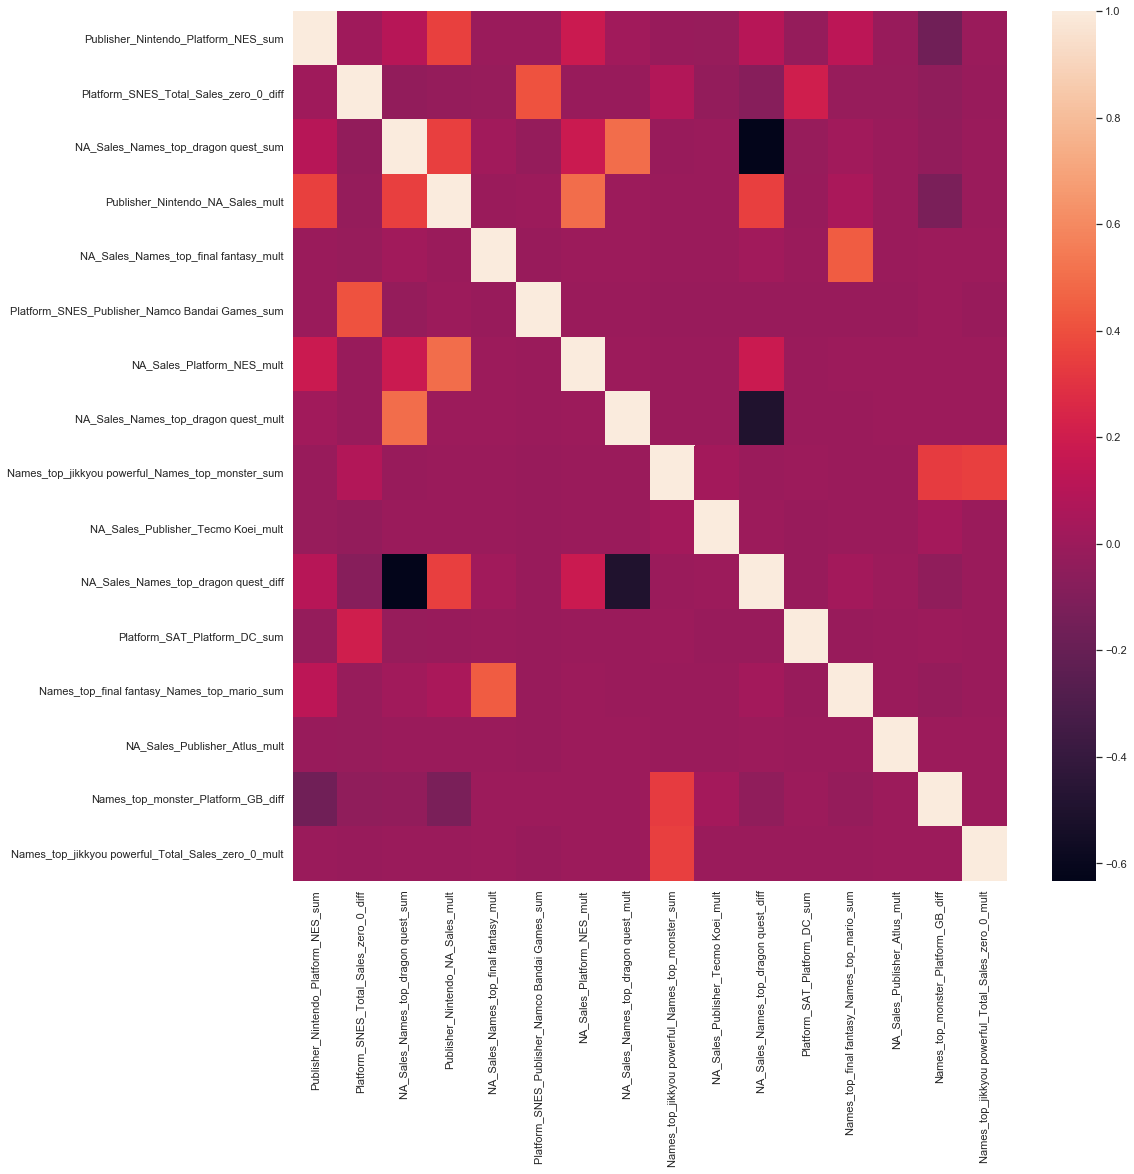

In [451]:
plt.figure(figsize=(16,16))
sns.heatmap(best_train.corr())

In [452]:
for col in best_train.columns:
    if best_train[col].nunique() == 3:
        best_train[col] = best_train[col].astype("category")
        best_test[col] = best_test[col].astype("category")

In [453]:
best_train = pd.get_dummies(best_train)
best_test = pd.get_dummies(best_test)

In [454]:
common_cols2 = [i for i in best_train.columns if i in best_test.columns]

In [455]:
best_train = best_train[common_cols2]
best_test = best_test[common_cols2]

In [456]:
best_train.corr()

,NA_Sales_Names_top_dragon quest_sum,Publisher_Nintendo_NA_Sales_mult,NA_Sales_Names_top_final fantasy_mult,NA_Sales_Platform_NES_mult,NA_Sales_Names_top_dragon quest_mult,Names_top_jikkyou powerful_Names_top_monster_sum,NA_Sales_Publisher_Tecmo Koei_mult,NA_Sales_Names_top_dragon quest_diff,Platform_SAT_Platform_DC_sum,Names_top_final fantasy_Names_top_mario_sum,...,Publisher_Nintendo_Platform_NES_sum_1.0,Platform_SNES_Total_Sales_zero_0_diff_0.0,Platform_SNES_Total_Sales_zero_0_diff_0.5,Platform_SNES_Total_Sales_zero_0_diff_1.0,Platform_SNES_Publisher_Namco Bandai Games_sum_0.0,Platform_SNES_Publisher_Namco Bandai Games_sum_0.5,Platform_SNES_Publisher_Namco Bandai Games_sum_1.0,Names_top_monster_Platform_GB_diff_0.0,Names_top_monster_Platform_GB_diff_0.5,Names_top_monster_Platform_GB_diff_1.0
NA_Sales_Names_top_dragon quest_sum,1.000000,0.346247,0.018163,0.177761,0.498700,-0.012754,-0.006478,-0.632707,-0.018507,0.018244,...,0.053250,0.039544,-0.039911,-0.001990,0.022607,-0.021560,-0.007616,0.042237,-0.032243,-0.005825
Publisher_Nintendo_NA_Sales_mult,0.346247,1.000000,-0.002344,0.501723,0.002873,-0.005342,-0.005193,0.347326,-0.008538,0.051089,...,0.172459,0.023672,-0.022070,-0.007893,0.000010,0.000576,-0.003292,0.147225,-0.122286,-0.002238
NA_Sales_Names_top_final fantasy_mult,0.018163,-0.002344,1.000000,-0.000315,-0.000843,-0.002883,-0.002374,0.020825,-0.003903,0.440349,...,-0.001884,0.016668,-0.016070,-0.003608,0.009180,-0.009037,-0.001505,-0.002687,0.003211,-0.001748
NA_Sales_Platform_NES_mult,0.177761,0.501723,-0.000315,1.000000,-0.000577,-0.001973,-0.001625,0.178599,-0.002671,0.000683,...,0.344348,0.011405,-0.010996,-0.002469,0.004050,-0.003922,-0.001030,-0.001838,0.002197,-0.001196
NA_Sales_Names_top_dragon quest_mult,0.498700,0.002873,-0.000843,-0.000577,1.000000,-0.002115,-0.001741,-0.492755,-0.002863,-0.001915,...,-0.001382,0.012224,-0.011786,-0.002646,0.006733,-0.006628,-0.001104,-0.001970,0.002355,-0.001282
Names_top_jikkyou powerful_Names_top_monster_sum,-0.012754,-0.005342,-0.002883,-0.001973,-0.002115,1.000000,0.029641,-0.005734,-0.000875,-0.006548,...,-0.004723,-0.086059,0.082649,0.019817,0.010976,-0.010454,-0.003773,-0.006736,-0.326304,0.606112
NA_Sales_Publisher_Tecmo Koei_mult,-0.006478,-0.005193,-0.002374,-0.001625,-0.001741,0.029641,1.000000,-0.000722,-0.008058,-0.005392,...,-0.003889,0.028716,-0.027351,-0.007449,0.010016,-0.009600,-0.003107,-0.005547,-0.025387,0.054849
NA_Sales_Names_top_dragon quest_diff,-0.632707,0.347326,0.020825,0.178599,-0.492755,-0.005734,-0.000722,1.000000,-0.008997,0.024426,...,0.057470,0.076535,-0.071325,-0.025635,0.013857,-0.013343,-0.003946,0.048457,-0.039785,-0.001582
Platform_SAT_Platform_DC_sum,-0.018507,-0.008538,-0.003903,-0.002671,-0.002863,-0.000875,-0.008058,-0.008997,1.000000,-0.008864,...,-0.006393,-0.224672,0.233165,-0.012246,0.013260,-0.012532,-0.005107,-0.009119,0.010898,-0.005931
Names_top_final fantasy_Names_top_mario_sum,0.018244,0.051089,0.440349,0.000683,-0.001915,-0.006548,-0.005392,0.024426,-0.008864,1.000000,...,0.015877,0.015296,-0.013419,-0.008194,0.011996,-0.011552,-0.003417,0.022251,-0.016493,-0.003969


In [457]:
common_cols2.remove("Platform_SNES_Publisher_Namco Bandai Games_sum_0.5")
common_cols2.remove("Platform_SNES_Total_Sales_zero_0_diff_0.5")
common_cols2.remove("Publisher_Nintendo_Platform_NES_sum_0.5")

In [458]:
best_train = best_train[common_cols2]
best_test = best_test[common_cols2]

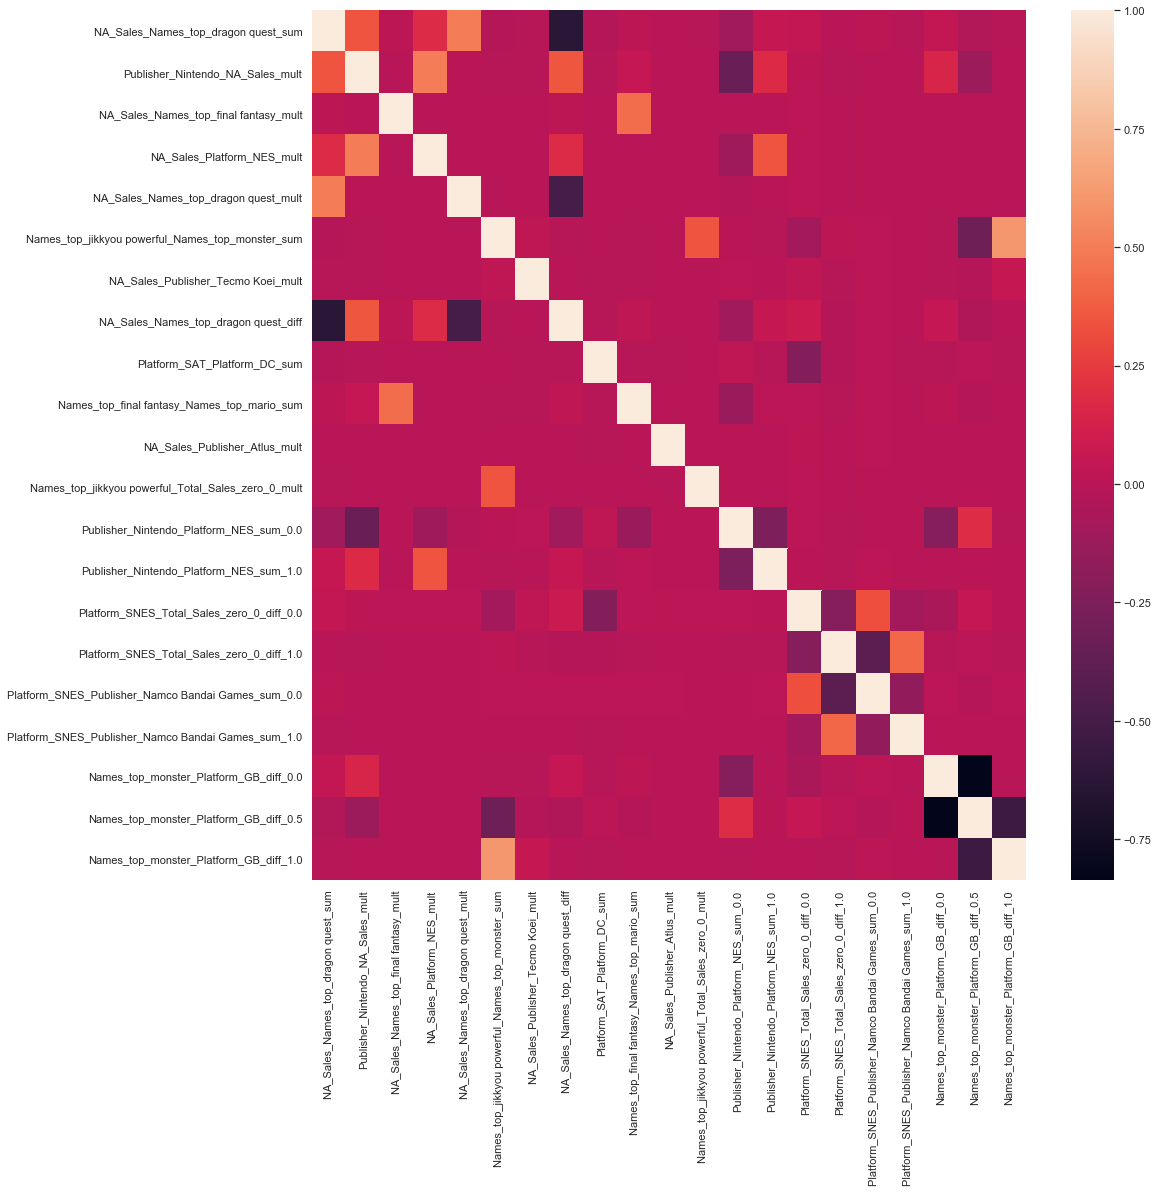

In [459]:
plt.figure(figsize=(16,16))
sns.heatmap(best_train.corr())

__Модели__

In [460]:
model1 = SGDRegressor(random_state=1) #linear model
model2 = RandomForestRegressor(random_state=1) #random forest
model3 = LGBMRegressor(random_state=1) # gradient boossting

In [461]:
params1 = {
    "penalty": [None, "l1", "l2", "elasticnet"],
    "alpha": [1e-5, 1e-4, 1e-3],
    "l1_ratio": [0.2, 0.4, 0.6, 0.8],
    "learning_rate": ["constant", "adaptive"],
    "eta0": [0.01, 0.001],
    "loss": ["squared_loss"],
    "random_state": [1],
    "max_iter": [10000],
    "tol": [1e-3],
    "verbose": [1]
}

params2 = {
    "n_estimators": [18, 20, 22, 24],
    "max_depth": [6, 8],
    "n_jobs": [-1],
    "verbose": [1],
    "random_state": [1]
}

params3= {
    "n_estimators": [400, 600, 800, 1000],
    "max_depth": [6, 8, 10],
    "num_leaves": [50, 75, 100, 150],
    "learning_rate": [0.01, 0.001],
    "n_jobs": [-1],
    "verbose": [1],
    "random_state": [1]
}

In [462]:
kf = KFold(5)

In [463]:
gs_1 = GridSearchCV(model1, params1, scoring="neg_mean_absolute_error",
                              n_jobs=-1, cv=kf, verbose=1)

gs_2 = GridSearchCV(model2, params2, scoring="neg_mean_absolute_error",
                              n_jobs=-1, cv=kf, verbose=1)

gs_3 = GridSearchCV(model3, params3, scoring="neg_mean_absolute_error",
                              n_jobs=-1, cv=kf, verbose=1)

In [464]:
X_train, X_test, y_train, y_test = train_test_split(best_train, y, test_size=0.25, random_state=1)

In [465]:
gs_1.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 652 tasks      | elapsed:    9.4s


-- Epoch 1
Norm: 0.84, NNZs: 21, Bias: 0.460314, T: 8777, Avg. loss: 0.043864
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.20, NNZs: 21, Bias: 0.580443, T: 17554, Avg. loss: 0.038788
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.39, NNZs: 21, Bias: 0.530598, T: 26331, Avg. loss: 0.037629
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 1.61, NNZs: 21, Bias: 0.559501, T: 35108, Avg. loss: 0.036752
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 1.78, NNZs: 21, Bias: 0.510275, T: 43885, Avg. loss: 0.036253
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 1.94, NNZs: 21, Bias: 0.498437, T: 52662, Avg. loss: 0.035830
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 2.07, NNZs: 21, Bias: 0.460147, T: 61439, Avg. loss: 0.035429
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 2.19, NNZs: 21, Bias: 0.427956, T: 70216, Avg. loss: 0.035059
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 2.22, NNZs: 21, Bias: 0.423585, T: 78993, Avg. loss: 0.034211
Total trai

[Parallel(n_jobs=-1)]: Done 953 out of 960 | elapsed:   13.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   13.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=1, shuffle=True,
                                    tol=0.00...
             param_grid={'alpha': [1e-05, 0.0001, 0.001], 'eta0': [0.01, 0.001],
                         'l1_ratio': [0.2, 0.4, 0.6, 0.8],
                         'learning_rate': ['constant', 'adaptive'],
                         'loss': ['squared_loss'], 'max_iter': [10000],
                         'penalty': [None, 'l1', 'l2', 'elasticnet'],

In [466]:
gs_1.best_params_

{'alpha': 1e-05,
 'eta0': 0.01,
 'l1_ratio': 0.2,
 'learning_rate': 'adaptive',
 'loss': 'squared_loss',
 'max_iter': 10000,
 'penalty': None,
 'random_state': 1,
 'tol': 0.001,
 'verbose': 1}

In [467]:
gs_2.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbo

In [468]:
gs_2.best_params_

{'max_depth': 8,
 'n_estimators': 24,
 'n_jobs': -1,
 'random_state': 1,
 'verbose': 1}

In [469]:
gs_3.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.4min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_sta...
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.001],
                         'max_depth': [6, 8, 10],
                         'n_estimators': [400, 600, 800, 1000], 'n_jobs': [-1],
                  

In [470]:
gs_3.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 600,
 'n_jobs': -1,
 'num_leaves': 50,
 'random_state': 1,
 'verbose': 1}

__Обучаем лучшую модель каждого семейства__

In [471]:
mod1 = SGDRegressor(alpha=1e-5,
                    eta0= 0.01,
                    l1_ratio=0.2,
     learning_rate= 'adaptive',
     loss= 'squared_loss',
     max_iter= 10000,
     penalty= None,
     random_state= 1,
     tol= 0.001,
     verbose= 1)

mod2 = RandomForestRegressor(max_depth= 8,
 n_estimators= 24,
 n_jobs= -1,
 random_state= 1,
 verbose= 1)

mod3 = LGBMRegressor(learning_rate= 0.01,
     max_depth= 10,
     n_estimators= 600,
     n_jobs= -1,
     num_leaves= 50,
     random_state= 1,
     verbose= 1
    )

In [472]:
mod1.fit(X_train, y_train)
preds1_train = mod1.predict(X_train) * 0.4
preds1_test = mod1.predict(X_test) * 0.4

err1_train = mean_absolute_error(y_train, preds1_train)
err1_test = mean_absolute_error(y_test, preds1_test)

-- Epoch 1
Norm: 0.84, NNZs: 21, Bias: 0.460314, T: 8777, Avg. loss: 0.043864
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.20, NNZs: 21, Bias: 0.580443, T: 17554, Avg. loss: 0.038788
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 1.39, NNZs: 21, Bias: 0.530598, T: 26331, Avg. loss: 0.037629
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 1.61, NNZs: 21, Bias: 0.559501, T: 35108, Avg. loss: 0.036752
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 1.78, NNZs: 21, Bias: 0.510275, T: 43885, Avg. loss: 0.036253
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 1.94, NNZs: 21, Bias: 0.498437, T: 52662, Avg. loss: 0.035830
Total training time: 0.03 seconds.
-- Epoch 7
Norm: 2.07, NNZs: 21, Bias: 0.460147, T: 61439, Avg. loss: 0.035429
Total training time: 0.03 seconds.
-- Epoch 8
Norm: 2.19, NNZs: 21, Bias: 0.427956, T: 70216, Avg. loss: 0.035059
Total training time: 0.03 seconds.
-- Epoch 9
Norm: 2.22, NNZs: 21, Bias: 0.423585, T: 78993, Avg. loss: 0.034211
Total trai

In [473]:
np.median(err1_train), np.median(err1_test)

(0.06998438147850329, 0.06894682027638552)

In [474]:
err1_train, err1_test

(0.06998438147850329, 0.06894682027638552)

In [475]:
mod2.fit(X_train, y_train)
preds2_train = mod2.predict(X_train) * 0.6
preds2_test = mod2.predict(X_test) * 0.6

err2_train = mean_absolute_error(y_train, preds2_train)
err2_test = mean_absolute_error(y_test, preds2_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    0.0s finished


In [476]:
err2_train, err2_test

(0.0662048375621636, 0.06619154371810058)

In [477]:
mod3.fit(X_train, y_train)
preds3_train = mod3.predict(X_train) * 0.5
preds3_test = mod3.predict(X_test) * 0.5

err3_train = mean_absolute_error(y_train, preds3_train)
err3_test = mean_absolute_error(y_test, preds3_test)

In [478]:
err3_train, err3_test

(0.06662969663772518, 0.06529859568239034)

In [479]:
mod4 = LinearRegression()

In [480]:
mod4.fit(X_train, y_train)
preds4_train = mod4.predict(X_train)
preds4_test = mod4.predict(X_test)

#err4_train = mean_absolute_error(y_train, preds4_train - 0.02)
#err4_test = mean_absolute_error(y_test, preds4_test - 0.02)